In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision.models.vgg import VGG
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.misc
import random
import sys

if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2

from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import numpy as np
import time
import os

In [2]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [3]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

## Define FCN16s model for deconvolution layers

In [4]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace = True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

## Define VGG16 for convolution layers

In [5]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):      
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x
        return output

In [6]:
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

## Define training parameter

In [7]:
batch_size = 8
epochs     = 200  #500
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 50
gamma      = 0.5
n_class = 5
model_use = "pst_gan"

## Define path, directory trainning environment

In [8]:
# get data
data_dir  = os.path.join("/media/arg_ws3/5E703E3A703E18EB/data/PST900_RGBT_Dataset/")
if not os.path.exists(data_dir):
    print("Data not found!")
# create dir for model
model_dir = os.path.join("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/models", model_use)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# create dir for score
score_dir = os.path.join("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/scores", model_use)
if not os.path.exists(score_dir):
    os.makedirs(score_dir)

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)
#use_gpu = False
if use_gpu:
    ts = time.time()
    vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))

Finish cuda loading, time elapsed 1.688988208770752


## GAN

In [9]:
fcn_temp = FCN16s(pretrained_net=vgg_model, n_class=n_class)
discriminator = Discriminator(in_channels = n_class + 3)
discriminator_adv = Discriminator(in_channels = n_class*2)
# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()
criterion_adv = torch.nn.L1Loss()
patch = (1, 480//2**4, 640//2**4)
# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

if use_gpu:
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()
    criterion_adv.cuda()
    fcn_temp = fcn_temp.cuda()
    fcn_temp = nn.DataParallel(fcn_temp, device_ids=num_gpu)
    discriminator_adv = discriminator_adv.cuda()
Tensor = torch.cuda.FloatTensor if use_gpu else torch.FloatTensor
discriminator.apply(weights_init_normal)
discriminator_adv.apply(weights_init_normal)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_adv_D = torch.optim.Adam(discriminator_adv.parameters(), lr=0.001, betas=(0.5, 0.999))

scheduler_d = lr_scheduler.StepLR(optimizer_D, step_size = step_size+10, gamma = gamma)
scheduler_adv = lr_scheduler.StepLR(optimizer_adv_D, step_size = step_size+10, gamma = gamma)  

In [10]:
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w      = 480, 640
val_h     = h
val_w     = w

class product_dataset(Dataset):

    def __init__(self, root, phase, n_class=n_class, flip_rate=0.):
        data_dir = os.path.join(root, phase)
        self.img_list = os.listdir(os.path.join(data_dir, 'rgb'))
        self.rgb_dir = os.path.join(data_dir, 'rgb')
        self.label_dir = os.path.join(data_dir, 'labels')
        self.means     = means
        self.n_class   = n_class
        self.flip_rate = flip_rate
        if phase == 'train':
            self.flip_rate = 0.5

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        idx = idx % len(self.img_list)
        print(idx)        
        img = cv2.imread(os.path.join(self.rgb_dir, self.img_list[idx]),cv2.IMREAD_UNCHANGED)
        label = cv2.imread(os.path.join(self.label_dir, self.img_list[idx]), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (640, 480), interpolation=cv2.INTER_CUBIC)
        label = cv2.resize(label, (640, 480), interpolation=cv2.INTER_CUBIC)
        origin_img = img
        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)

        # reduce mean
        img = img[:, :, ::-1]  # switch to BGR
        
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.size()
        target = torch.zeros(self.n_class, h, w)
        
        for i in range(n_class):
            target[i][label == i] = 1
        
        #target[0][label == 0] = 1
        #print(np.unique(label))
        
 
        sample = {'X': img, 'Y': target, 'l': label, 'origin': origin_img}

        return sample

## Define dataloader and optimizer

In [11]:
# initial dataloader for trainning and validation
train_data = product_dataset(data_dir, phase = 'train')
val_data   = product_dataset(data_dir, phase = 'test', flip_rate = 0)
dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True, num_workers = 0)
val_loader = DataLoader(val_data, batch_size = 1, num_workers = 0)

dataiter = iter(val_loader)

# define loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(fcn_model.parameters(), lr = lr, momentum = momentum, weight_decay = w_decay)
# decay LR by a factor of 0.5 every step_size = 50 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)  

In [12]:
len(dataiter)

288

## Train

In [13]:
def train():
    for epoch in range(epochs):
        fcn_model.train()
        scheduler.step()
        scheduler_d.step()
        scheduler_adv.step()
        configs    = "FCNs_batch{}_epoch{}_RMSprop_lr{}"\
            .format(batch_size, epoch, lr)
        model_path = os.path.join(model_dir, configs)
        
        ts = time.time()
        for iter, batch in enumerate(dataloader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['Y'].cuda())
            else:
                inputs, labels = Variable(batch['X']), Variable(batch['Y'])

            valid = Variable(Tensor(np.ones((labels.size(0), *patch))), requires_grad=False)
            fake = Variable(Tensor(np.zeros((labels.size(0), *patch))), requires_grad=False)
                
            outputs = fcn_model(inputs)
            temp = fcn_temp(inputs).detach()
            # GAN loss
            pred_fake = discriminator(outputs, inputs)
            loss_GAN = criterion_GAN(pred_fake, valid)
            # ADV loss
            #pred_adv = discriminator_adv(outputs, temp)
            #loss_adv = criterion_adv(pred_adv, valid)
            # Pixel-wise loss
            loss_pixel = criterion(outputs, labels)
            #loss_G = 0.005 * loss_GAN + loss_pixel + 0.005 * loss_adv
            #loss_G = loss_pixel + 0.01 * loss_adv
            loss_G = 0.005 * loss_GAN + loss_pixel
            loss_G.backward()
            optimizer.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_adv_D.zero_grad()
            optimizer_D.zero_grad()

            # Real loss
            pred_real = discriminator(labels, inputs)
            loss_real = criterion_GAN(pred_real, valid)
            #pred_adv_real = discriminator_adv(outputs.detach(),labels)
            #loss_adv_real = criterion_adv(pred_adv_real, valid)

            # Fake loss
            pred_fake = discriminator(outputs.detach(), inputs)
            loss_fake = criterion_GAN(pred_fake, fake)
            #pred_adv_fake = discriminator_adv(outputs.detach(), temp)
            #loss_adv_fake = criterion_adv(pred_adv_fake, fake)

            # Total loss
            #loss_D = 0.25*0.5 * (loss_real + loss_fake) + 0.25*0.5 * (loss_adv_real + loss_adv_fake)
            #loss_D = 0.5 * (loss_adv_real + loss_adv_fake)
            loss_D = 0.5 * (loss_real + loss_fake)

            loss_D.backward()
            optimizer_D.step()
            optimizer_adv_D.step()
            
            if iter % 80 == 0:
                fcn_temp.load_state_dict(fcn_model.state_dict())
                print("Load temp")
            
            if iter % 10 == 0:
                #print("epoch{}, iter{}, loss_G: {}, loss_D: {}".format(epoch+1, iter, loss_G.item(), loss_D.item()))
                print("epoch{}, iter{}, loss_G: {}".format(epoch+1, iter, loss_G.item()))
        
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        if epoch % 4 == 0:
            torch.save(fcn_model.state_dict(),model_path + '.pkl')

        val(epoch)

## Evaluation

In [14]:
def val(epoch):
    fcn_model.eval()
    TP = np.zeros(n_class-1, dtype = np.float128)
    FN = np.zeros(n_class-1, dtype = np.float128)
    FP = np.zeros(n_class-1, dtype = np.float128)
    total_ious = []
    pixel_accs = []
    for iter, batch in enumerate(val_loader):
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
        else:
            inputs = Variable(batch['X'])

        output = fcn_model(inputs)
        output = output.data.cpu().numpy()

        N, _, h, w = output.shape
        pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)

        target = batch['l'].cpu().numpy().reshape(N, h, w)
        for p, t in zip(pred, target):
            pixel_accs.append(pixel_acc(p, t))
            _TP, _FN, _FP =  analysis(p, t, h, w)
            TP += _TP[1:n_class]
            FN += _FN[1:n_class]
            FP += _FP[1:n_class]
            
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
    #print("epoch{}, pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
    #      .format(epoch, pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
    print("epoch{}, meanIoU: {}".format(epoch, np.nanmean(ious)))
    
    f1 = open(score_dir + "/cls_acc_log.txt","a+")
    f1.write('epoch:'+ str(epoch) + ', pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(score_dir + "/cls_iou_log.txt","a+")
    f2.write('epoch:'+ str(epoch) + ', class ious: ' + str(ious) + '\n' )
    f3 = open(score_dir + "/mean_iou_log.txt","a+")
    f3.write('epoch:'+ str(epoch) + ', mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(score_dir + "/recall_log.txt","a+")
    f4.write('epoch:'+ str(epoch) + ', class recall: ' + str(recall) + '\n' )
    f5 = open(score_dir + "/precision_log.txt","a+")
    f5.write('epoch:'+ str(epoch) + ', class precision: ' + str(precision) + '\n' )    
    f6 = open(score_dir + "/fscore_log.txt","a+")
    f6.write('epoch:'+ str(epoch) + ', class fscore: ' + str(fscore) + '\n' )  
    f7 = open(score_dir + "/mean_fscore_log.txt","a+")
    f7.write('epoch:'+ str(epoch) + ', mean fscore: ' + str(np.nanmean(fscore)) + '\n' )
    f8 = open(score_dir + "/mean_precision_log.txt","a+")
    f8.write('epoch:'+ str(epoch) + ', mean precision: ' + str(np.nanmean(precision)) + '\n' ) 
    f9 = open(score_dir + "/mean_recall_log.txt","a+")
    f9.write('epoch:'+ str(epoch) + ', mean recall: ' + str(np.nanmean(recall)) + '\n' ) 
    

def analysis(pred, target, h, w):
    # TP, FN, FP, TN
    TP = np.zeros(n_class, dtype = np.float128)
    FN = np.zeros(n_class, dtype = np.float128)
    FP = np.zeros(n_class, dtype = np.float128)

    target = target.reshape(h * w)
    pred = pred.reshape(h * w)

    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,n_class,1))
    con_matrix[0][0] = 0
    for i in range(0, n_class):
        for j in range(0, n_class):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    return TP, FN, FP
                
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [15]:
train()

Load temp
epoch1, iter0, loss_G: 0.7114716172218323
epoch1, iter10, loss_G: 0.6842726469039917
epoch1, iter20, loss_G: 0.6731190085411072
epoch1, iter30, loss_G: 0.6681295037269592
epoch1, iter40, loss_G: 0.6643367409706116
epoch1, iter50, loss_G: 0.6615403294563293
epoch1, iter60, loss_G: 0.6581804752349854
epoch1, iter70, loss_G: 0.6541536450386047
Finish epoch 0, time elapsed 184.3413016796112
epoch0, meanIoU: 0.07646719142138875
Load temp
epoch2, iter0, loss_G: 0.6527432203292847
epoch2, iter10, loss_G: 0.652901828289032
epoch2, iter20, loss_G: 0.6486629843711853
epoch2, iter30, loss_G: 0.6566594243049622
epoch2, iter40, loss_G: 0.6429157257080078
epoch2, iter50, loss_G: 0.6405560374259949
epoch2, iter60, loss_G: 0.6457427144050598
epoch2, iter70, loss_G: 0.6345627903938293
Finish epoch 1, time elapsed 173.33805322647095
epoch1, meanIoU: 0.0921495144195478
Load temp
epoch3, iter0, loss_G: 0.6380290389060974
epoch3, iter10, loss_G: 0.6383205652236938
epoch3, iter20, loss_G: 0.631022

epoch19, iter50, loss_G: 0.2710646390914917
epoch19, iter60, loss_G: 0.2715550661087036
epoch19, iter70, loss_G: 0.2715493142604828
Finish epoch 18, time elapsed 177.7223105430603
epoch18, meanIoU: 0.33711714338294035
Load temp
epoch20, iter0, loss_G: 0.2682565748691559
epoch20, iter10, loss_G: 0.2814297676086426
epoch20, iter20, loss_G: 0.26848068833351135
epoch20, iter30, loss_G: 0.2533334195613861
epoch20, iter40, loss_G: 0.2657523453235626
epoch20, iter50, loss_G: 0.26654860377311707
epoch20, iter60, loss_G: 0.24004478752613068
epoch20, iter70, loss_G: 0.2350233793258667
Finish epoch 19, time elapsed 188.96748900413513
epoch19, meanIoU: 0.45697080024503706
Load temp
epoch21, iter0, loss_G: 0.24926038086414337
epoch21, iter10, loss_G: 0.24436970055103302
epoch21, iter20, loss_G: 0.2306211292743683
epoch21, iter30, loss_G: 0.2527685761451721
epoch21, iter40, loss_G: 0.23137053847312927
epoch21, iter50, loss_G: 0.2501167356967926
epoch21, iter60, loss_G: 0.2214694321155548
epoch21, it

epoch37, iter70, loss_G: 0.049798011779785156
Finish epoch 36, time elapsed 188.96294498443604
epoch36, meanIoU: 0.6161746143161712
Load temp
epoch38, iter0, loss_G: 0.05040311440825462
epoch38, iter10, loss_G: 0.048211608082056046
epoch38, iter20, loss_G: 0.05023852735757828
epoch38, iter30, loss_G: 0.05776007100939751
epoch38, iter40, loss_G: 0.04849370941519737
epoch38, iter50, loss_G: 0.04640010744333267
epoch38, iter60, loss_G: 0.045405156910419464
epoch38, iter70, loss_G: 0.04565765708684921
Finish epoch 37, time elapsed 190.4831986427307
epoch37, meanIoU: 0.6388618803284704
Load temp
epoch39, iter0, loss_G: 0.044318657368421555
epoch39, iter10, loss_G: 0.043673865497112274
epoch39, iter20, loss_G: 0.04536345601081848
epoch39, iter30, loss_G: 0.04433104395866394
epoch39, iter40, loss_G: 0.04489021375775337
epoch39, iter50, loss_G: 0.042005255818367004
epoch39, iter60, loss_G: 0.04265385866165161
epoch39, iter70, loss_G: 0.039942990988492966
Finish epoch 38, time elapsed 191.10652

epoch55, iter60, loss_G: 0.013501960784196854
epoch55, iter70, loss_G: 0.013603642582893372
Finish epoch 54, time elapsed 190.55180072784424
epoch54, meanIoU: 0.6213841447592161
Load temp
epoch56, iter0, loss_G: 0.012780833058059216
epoch56, iter10, loss_G: 0.013517694547772408
epoch56, iter20, loss_G: 0.013218553736805916
epoch56, iter30, loss_G: 0.01255983766168356
epoch56, iter40, loss_G: 0.011841986328363419
epoch56, iter50, loss_G: 0.01182679645717144
epoch56, iter60, loss_G: 0.012533350847661495
epoch56, iter70, loss_G: 0.011909157037734985
Finish epoch 55, time elapsed 188.90321850776672
epoch55, meanIoU: 0.618604545557754
Load temp
epoch57, iter0, loss_G: 0.011885914020240307
epoch57, iter10, loss_G: 0.01173434965312481
epoch57, iter20, loss_G: 0.012084648944437504
epoch57, iter30, loss_G: 0.012224892154335976
epoch57, iter40, loss_G: 0.012843783013522625
epoch57, iter50, loss_G: 0.01277298666536808
epoch57, iter60, loss_G: 0.013979136943817139
epoch57, iter70, loss_G: 0.016099

epoch73, iter40, loss_G: 0.009821035899221897
epoch73, iter50, loss_G: 0.008428893983364105
epoch73, iter60, loss_G: 0.008170785382390022
epoch73, iter70, loss_G: 0.007850581780076027
Finish epoch 72, time elapsed 190.69340324401855
epoch72, meanIoU: 0.5000078064399738
Load temp
epoch74, iter0, loss_G: 0.008919856511056423
epoch74, iter10, loss_G: 0.007624540477991104
epoch74, iter20, loss_G: 0.00850010383874178
epoch74, iter30, loss_G: 0.009952357038855553
epoch74, iter40, loss_G: 0.008342972956597805
epoch74, iter50, loss_G: 0.008349930867552757
epoch74, iter60, loss_G: 0.00800984539091587
epoch74, iter70, loss_G: 0.007799199782311916
Finish epoch 73, time elapsed 189.15793013572693
epoch73, meanIoU: 0.6066149125984885
Load temp
epoch75, iter0, loss_G: 0.008320721797645092
epoch75, iter10, loss_G: 0.008798627182841301
epoch75, iter20, loss_G: 0.007883027195930481
epoch75, iter30, loss_G: 0.00829373486340046
epoch75, iter40, loss_G: 0.0087254848331213
epoch75, iter50, loss_G: 0.008125

epoch91, iter20, loss_G: 0.006824172101914883
epoch91, iter30, loss_G: 0.008253874257206917
epoch91, iter40, loss_G: 0.006063641048967838
epoch91, iter50, loss_G: 0.005758635699748993
epoch91, iter60, loss_G: 0.006831085775047541
epoch91, iter70, loss_G: 0.006900612264871597
Finish epoch 90, time elapsed 188.9549684524536
epoch90, meanIoU: 0.6316672994929068
Load temp
epoch92, iter0, loss_G: 0.006719372700899839
epoch92, iter10, loss_G: 0.007126046344637871
epoch92, iter20, loss_G: 0.008311880752444267
epoch92, iter30, loss_G: 0.006760992109775543
epoch92, iter40, loss_G: 0.006960689090192318
epoch92, iter50, loss_G: 0.00730482442304492
epoch92, iter60, loss_G: 0.007425402291119099
epoch92, iter70, loss_G: 0.008092912845313549
Finish epoch 91, time elapsed 188.81288814544678
epoch91, meanIoU: 0.6262518598117116
Load temp
epoch93, iter0, loss_G: 0.008088486269116402
epoch93, iter10, loss_G: 0.00810721330344677
epoch93, iter20, loss_G: 0.008741110563278198
epoch93, iter30, loss_G: 0.0072

Finish epoch 107, time elapsed 190.94072556495667
epoch107, meanIoU: 0.5337307212379322
Load temp
epoch109, iter0, loss_G: 0.006967941764742136
epoch109, iter10, loss_G: 0.006076008081436157
epoch109, iter20, loss_G: 0.006582166068255901
epoch109, iter30, loss_G: 0.0071492320857942104
epoch109, iter40, loss_G: 0.007087642326951027
epoch109, iter50, loss_G: 0.007107868790626526
epoch109, iter60, loss_G: 0.0060746255330741405
epoch109, iter70, loss_G: 0.007121367380023003
Finish epoch 108, time elapsed 191.01943159103394
epoch108, meanIoU: 0.6529610967416063
Load temp
epoch110, iter0, loss_G: 0.006350534036755562
epoch110, iter10, loss_G: 0.007141437381505966
epoch110, iter20, loss_G: 0.007354301400482655
epoch110, iter30, loss_G: 0.007478619925677776
epoch110, iter40, loss_G: 0.006818278692662716
epoch110, iter50, loss_G: 0.006321165710687637
epoch110, iter60, loss_G: 0.005960498470813036
epoch110, iter70, loss_G: 0.006483207922428846
Finish epoch 109, time elapsed 189.95894742012024
ep

epoch126, iter20, loss_G: 0.006364778149873018
epoch126, iter30, loss_G: 0.006226847879588604
epoch126, iter40, loss_G: 0.006249804049730301
epoch126, iter50, loss_G: 0.007329525426030159
epoch126, iter60, loss_G: 0.006479816511273384
epoch126, iter70, loss_G: 0.007072777487337589
Finish epoch 125, time elapsed 176.04960131645203
epoch125, meanIoU: 0.6338424248432163
Load temp
epoch127, iter0, loss_G: 0.006970306392759085
epoch127, iter10, loss_G: 0.00735816452652216
epoch127, iter20, loss_G: 0.0063297925516963005
epoch127, iter30, loss_G: 0.006360451690852642
epoch127, iter40, loss_G: 0.007328645326197147
epoch127, iter50, loss_G: 0.0065071796998381615
epoch127, iter60, loss_G: 0.006680469959974289
epoch127, iter70, loss_G: 0.007278950419276953
Finish epoch 126, time elapsed 177.67084860801697
epoch126, meanIoU: 0.6203290657627565
Load temp
epoch128, iter0, loss_G: 0.006076605059206486
epoch128, iter10, loss_G: 0.006544806063175201
epoch128, iter20, loss_G: 0.006945042870938778
epoch1

epoch143, iter60, loss_G: 0.00641092611476779
epoch143, iter70, loss_G: 0.006022678688168526
Finish epoch 142, time elapsed 175.8942675590515
epoch142, meanIoU: 0.5987956458512326
Load temp
epoch144, iter0, loss_G: 0.007107192650437355
epoch144, iter10, loss_G: 0.006262770388275385
epoch144, iter20, loss_G: 0.017755169421434402
epoch144, iter30, loss_G: 0.007090166676789522
epoch144, iter40, loss_G: 0.006808700039982796
epoch144, iter50, loss_G: 0.006608843803405762
epoch144, iter60, loss_G: 0.0071245827712118626
epoch144, iter70, loss_G: 0.0060526239685714245
Finish epoch 143, time elapsed 175.6748263835907


KeyboardInterrupt: 

## Prediction Result

In [281]:
val_data   = product_dataset(data_dir, phase = 'test', flip_rate = 0)
val_loader = DataLoader(val_data, batch_size = 1, num_workers = 0)
dataiter = iter(val_loader)

In [349]:
def prediction(model_name):
    
    # load pretrain models
    state_dict = torch.load(os.path.join(model_name))
    fcn_model.load_state_dict(state_dict)
    
    batch = dataiter.next()
    if use_gpu:
        inputs = Variable(batch['X'].cuda())
    else:
        inputs = Variable(batch['X'])
    img    = batch['origin'] 
    label  = batch['l']
    
    #print(img.shape, inputs.shape)
    #print(inputs[0])
    
    output = fcn_model(inputs)
    output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    # show images
    plt.figure(figsize = (10, 12))
    img = img.numpy()
    for i in range(N):
        img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
        plt.subplot(N, 3, i*3 + 1)
        plt.title("origin_img")
        plt.imshow(img[i])
        #print(np.unique(_img[i]))

        plt.subplot(N, 3, i*3 + 2)
        plt.title("label_img")
        plt.imshow(label[i],cmap = "nipy_spectral",vmin = 0, vmax = n_class - 1)

        plt.subplot(N, 3, i*3 + 3)
        plt.title("prediction")
        plt.imshow(pred[i],cmap = "nipy_spectral",vmin = 0, vmax = n_class - 1)
    y = pred[0].astype(np.uint8)
    #y = cv2.cvtColor(y, cv2.COLOR_GRAY2RGB)
    plt.imsave("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/models/pst/b_6.jpg", y, cmap='nipy_spectral',vmin = 0, vmax = n_class - 1)
    #cv2.imwrite("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/models/pst/a.jpg", y)
    plt.show()

131


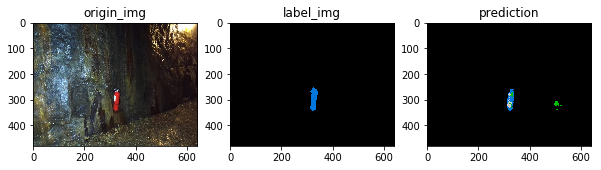

In [416]:
prediction("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/models/pst_gan/FCNs_batch8_epoch140_RMSprop_lr0.0001.pkl")